In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import re
import string
import torch
import nltk
import unicodedata
import spacy
import random

import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter

from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from gensim.models import KeyedVectors

from snowballstemmer import stemmer

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

from torch.utils.data import TensorDataset

In [3]:
nltk.download('punkt')
nltk.download('omw')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\theodoros.minaidis\AppData\Roaming\nltk_data.
[nltk_data]     ..
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw to
[nltk_data]     C:\Users\theodoros.minaidis\AppData\Roaming\nltk_data.
[nltk_data]     ..
[nltk_data]   Package omw is already up-to-date!


True

In [4]:
#  -- Code from exercise 1 (improved) --  #

def cleaning_txt(data):
    data = re.sub(r'@\S+', '', data)
    data = re.sub(r'#','',data)
    return data

def cleaning_punctuations(data):
    translator = str.maketrans('', '', string.punctuation)
    return data.translate(translator)

def cleaning_repeating_char(data):
    return re.sub(r'(.)1+', r'1', data)

def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)

def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

def split_stacked_words(data):
    if not isinstance(data, str):
        return data
    pattern = re.compile(r'([α-ωά-ώ])([Α-ΩΆ-Ώ])', re.UNICODE)
    data = re.sub(pattern, r'\1 \2', data)  #Add a space
    return data

def remove_greek_numerals(data):
    # Define a regular expression pattern to match Greek numerals
    greek_numeral_pattern = re.compile(r'\b(?:Ένα|Δύο|Τρία|Τέσσερα|Πέντε|Έξι|Επτά|Οκτώ|Εννέα|Δέκα|Έντεκα|Δώδεκα|Δεκατρία|Δεκατέσσερα|Δεκαπέντε|Δεκαέξι|Δεκαεπτά|Δεκαοκτώ|Δεκαεννέα|Είκοσι|Τριάντα|Σαράντα|Πενήντα|Εξήντα|Εβδομήντα|Ογδοήντα|Ενενήντα|Εκατό|Χίλια|ένα|δύο|τρία|τέσσερα|πέντε|έξι|επτά|οκτώ|εννέα|δέκα|έντεκα|δώδεκα|δεκατρία|δεκατέσσερα|δεκαπέντε|δεκαέξι|δεκαεπτά|δεκαοκτώ|δεκαεννέα|είκοσι|τριάντα|σαράντα|πενήντα|εξήντα|εβδομήντα|ογδοήντα|ενενήντα|εκατό|χίλια)\b', re.UNICODE)
    # Replace matched Greek numerals with an empty string
    cleaned_text = re.sub(greek_numeral_pattern, '', data)
    return cleaned_text

def remove_single_letter_words(data):
    single_letter_word_pattern = re.compile(r'\b\w\b')
    # Replace matched single-letter words with an empty string
    cleaned_text = re.sub(single_letter_word_pattern, '', data)
    return cleaned_text

greek_stopwords = set(stopwords.words('greek'))
greek_stemmer = stemmer("greek")
more_useless_words = ['ειναι','εχει','αλλιως','«','»']
min_word_length = 4

# it's almost impossible a word under 3 letter be useful. So i delete them all
def remove_greek_stopwords(data):
    words = data.split()
    filtered_words = [word for word in words if word.lower() not in greek_stopwords and word.lower() not in more_useless_words and len(word) >= min_word_length]
    return ' '.join(filtered_words)

# remove only tones
def remove_diacritics(data):
    return ''.join(char for char in unicodedata.normalize('NFD', data) if unicodedata.category(char) != 'Mn')

def tokenize_twitter(data):
    return word_tokenize(data)

def lemmatization(data):
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(data)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

def stemming_and_making_txt(data):
    stemmed_words = [greek_stemmer.stemWord(word) for word in data]
    stemmed_txt = ' '.join(stemmed_words)
    return stemmed_txt

#  -- New code for exercise 2 --  #

# Pytorch dataset #
def get_embeddings(tokens, model):
    embeddings = [model.wv[word] for word in tokens if word in model.wv]
    return sum(embeddings) / len(embeddings) if embeddings else None

# Function for subsampling
def subsample(word_list, word_frequency, threshold=1e-5):
    sampled_words = []

    for word in word_list:
        prob = 1 - (threshold / (word_frequency.get(word, 0) + threshold))   # Calculate the probability of keeping the word for each row
        if random.uniform(0, 1) < prob:                                      # Keep the word with probability 'prob'
            sampled_words.append(word)
    
    return sampled_words

# Function for shrinking 
def shrinking(word_list,threshold=1e-5):
    
    shrunken_text = [word for word in word_list if np.random.rand() > threshold]  # Adjust the threshold as needed
    return shrunken_text

def total_cleaning(df):
    # -- Cleaning text -- 
    df['text'] = df['text'].apply(lambda x: cleaning_txt(x)) # Cleaning # and @anythinng
    df['text'] = df['text'].apply(lambda x: cleaning_repeating_char(x)) # Cleaning repeating characters 
    df['text'] = df['text'].apply(lambda x: cleaning_URLs(x)) # Cleaning URLs
    df['text'] = df['text'].apply(lambda x: cleaning_punctuations(x)) # Cleaning punctuations
    df['text'] = df['text'].apply(lambda x: cleaning_numbers(x)) # Cleaning numbers 0-9 and all greek numbers 
    df['text'] = df['text'].apply(lambda x: split_stacked_words(x))
    df['text'] = df['text'].apply(lambda x: remove_greek_numerals(x))
    df['text'] = df['text'].apply(lambda x: remove_single_letter_words(x))
    df['text'] = df['text'].apply(lambda x: remove_greek_stopwords(x))
#     df['text'] = df['text'].apply(lambda x: lemmatization(x))
    df['text'] = df['text'].apply(lambda x: remove_diacritics(x))

    # -- Text tokenization and stemming--
    df['text'] = df['text'].apply(lambda x: word_tokenize(x))
    df['text'] = df['text'].apply(lambda x: stemming_and_making_txt(x))
    
    #   ---------- Subsampling - Shrinking ----------   #

    df['text'] = df['text'].apply(lambda x:word_tokenize(x))                                                      #  <- Again tokenize the context                  #

    word_frequency = {}
    for tokens in df['text']:
        for word in tokens:
            if word in word_frequency:
                word_frequency[word] += 1
            else:
                word_frequency[word] = 1

    df['text'] = df['text'].apply(lambda x: subsample(x,word_frequency))                                       #  <- Make sumsamble for the word2vec             #
    df['text'] = df['text'].apply(lambda x: shrinking(x)) 
         
    return df




 -------------- --- Data Process --- ----------------

 --- Csv files are readed --- 
 --- Cleaning started: Process 0% --- 
 --- Training set Cleaning Completed: Process 80% --- 
 --- Valid set Cleaning Completed: Process 100% --- 

 ------------ --- Data Process Done --- --------------



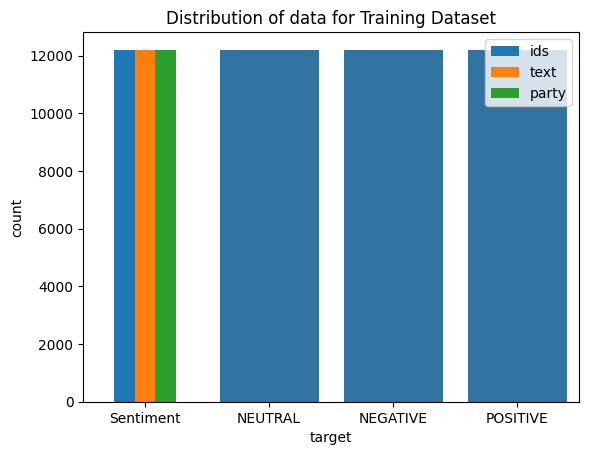

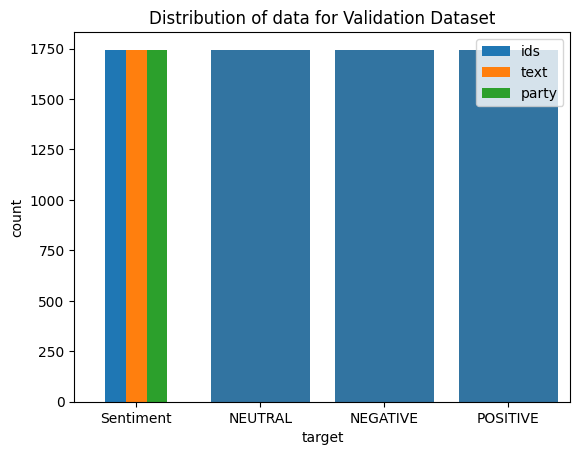

In [5]:
print("\n -------------- --- Data Process --- ----------------\n")


# Dataset encoding and columns names
DATASET_COLUMNS=['ids','text','target','party']
DATASET_ENCODING = "UTF-8"

# Reading train and valid set and adding both on a DataFrame (df)
df = pd.read_csv('csv/train_set.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df2 = pd.read_csv('csv/valid_set.csv',encoding=DATASET_ENCODING,names=DATASET_COLUMNS)

print(" --- Csv files are readed --- ")

# Plotting the distribution for dataset.
ax = df.groupby('target').count().plot(kind='bar', title='Distribution of data for Training Dataset',legend=False)
ax.set_xticklabels(['Sentiment','NEUTRAL','NEGATIVE','POSITIVE'], rotation=0)

# Storing data in lists.
sns.countplot(x='target', data=df)

# Plotting the distribution for dataset.
ax = df2.groupby('target').count().plot(kind='bar', title='Distribution of data for Validation Dataset',legend=False)
ax.set_xticklabels(['Sentiment','NEUTRAL','NEGATIVE','POSITIVE'], rotation=0)

# Storing data in lists.
sns.countplot(x='target', data=df2)

print(" --- Cleaning started: Process 0% --- ")
df = total_cleaning(df)
print(" --- Training set Cleaning Completed: Process 80% --- ")
df2 = total_cleaning(df2)
print(" --- Valid set Cleaning Completed: Process 100% --- ")

print("\n ------------ --- Data Process Done --- --------------\n")


In [6]:
# RNN class
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd

class RNN(nn.Module):
    """
    Wrapper module for RNN, LSTM, GRU cells using PyTorch API. The output is fed to a FFN for classification.
    """
    def __init__(self, cell_type, input_size, hidden_size, num_layers, output_size, dropout, skipconn=True, grad_clip=True):
        super(RNN, self).__init__()

        cells = {
            "RNN": nn.RNN,
            "LSTM": nn.LSTM,
            "GRU": nn.GRU
        }
        self.cell_type = cell_type
        self.skipconn = skipconn
        self.grad_clip = grad_clip
        if skipconn == False:
            self.rnn = cells[cell_type](
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True,
                bidirectional=True,
                dropout=dropout
            )
            if self.rnn.bidirectional == True:
                self.out = nn.Linear(hidden_size*2, output_size)  # Feed forward network
            else:
                self.out = nn.Linear(hidden_size, output_size)  # Feed forward network
        else:
            layers = []
            for i in range(num_layers):
                layers.append(cells[cell_type](
                    input_size=input_size,
                    hidden_size=hidden_size,
                    num_layers=1,
                    batch_first=True,
                    bidirectional=True,
                    dropout=dropout
                ))
            self.rnn = nn.Sequential(*layers)
            self.out = nn.Linear(hidden_size*2, output_size)  # Feed forward network

            if self.skipconn:
                self.hidden_dim = self.rnn[0].hidden_size
                self.num_layers = self.rnn[0].num_layers
            else:
                self.hidden_dim = self.rnn.hidden_size
                self.num_layers = self.rnn.num_layers

    def forward(self, x):
        if self.cell_type == 'LSTM':
            if self.skipconn:
                r_out, (h_n, h_c) = self.rnn[0](x)
            else:
                r_out, (h_n, h_c) = self.rnn(x)
        else:
            if self.skipconn:
                r_out, h_n = self.rnn[0](x)
            else:
                r_out, h_n = self.rnn(x)

        if self.skipconn:
            for i in range(0, self.num_layers-1):
                output1 = r_out
                out, h_n = self.rnn[i](r_out)
                output, h_n = self.rnn[i+1](out)
                r_out = output + output1

        out = self.out(r_out)
        return out

# Define model and optimizer
embedding_dim = 128  # Size of Word2Vec embeddings
hidden_dim = 64 # Size of the hidden state
output_dim = 3  # Number of classes (positive, negative, neutral)            

criterion = nn.CrossEntropyLoss()

In [7]:
train_dataset = df.iloc[1:]
valid_dataset= df2.iloc[1:]

w2v_model = Word2Vec(sentences=train_dataset['text'].tolist(), vector_size=embedding_dim, window=5, min_count=1, workers=4)   #  Train a Word2Vec model on the subsampled text  #
w2v_model.save("word2vec_model.model") # save word2vec model

train_dataset = train_dataset.copy()
train_dataset['word_embeddings'] = train_dataset['text'].apply(lambda x: get_embeddings(x, w2v_model))
valid_dataset = valid_dataset.copy()
valid_dataset['word_embeddings'] = valid_dataset['text'].apply(lambda x: get_embeddings(x, w2v_model))

train_dataset = train_dataset.dropna(subset=['word_embeddings'])
valid_dataset = valid_dataset.dropna(subset=['word_embeddings'])


train_labels = train_dataset['target']
valid_labels = valid_dataset['target']

# --- Tensor Use --- 
train_features = torch.stack([torch.tensor(embedding) for embedding in train_dataset['word_embeddings'].dropna().tolist()])

label_encoder = LabelEncoder()
train_labels = torch.tensor(label_encoder.fit_transform(train_dataset['target'].dropna()), dtype=torch.long)

valid_features = torch.stack([torch.tensor(embedding) for embedding in valid_dataset['word_embeddings'].dropna().tolist()])
valid_labels = torch.tensor(label_encoder.transform(valid_dataset['target'].dropna()), dtype=torch.long)

# Create DataLoader for batch processing
# --- Creating Tensor Datasets ---
train_data = TensorDataset(train_features, train_labels)
valid_data = TensorDataset(valid_features, valid_labels)

# --- Creating the Loaders using DataLoader ---
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)


In [8]:
import optuna

def objective(trial):
    # Define hyperparameters to optimize
    input_size = 128
    hidden_size = trial.suggest_int('hidden_size', 32, 128)
    num_layers = trial.suggest_int('num_layers', 1, 4)
    output_size = 10
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    cell_type = 'LSTM'

    # Create model with suggested hyperparameters
    model = RNN(cell_type, input_size, hidden_size, num_layers, output_size, dropout)

    # Define optimizer with suggested learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 5
    for epoch in range(num_epochs):
        model.train()
        for batch_inputs, batch_labels in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_correct = 0
        val_total = 0
        for val_batch_inputs, val_batch_labels in valid_loader:
            val_outputs = model(val_batch_inputs)
            _, val_predicted = torch.max(val_outputs, 1)
            val_total += val_batch_labels.size(0)
            val_correct += (val_predicted == val_batch_labels).sum().item()

        val_accuracy = 100 * val_correct / val_total
    return val_accuracy

print("-- Using Optuna to find the best hyperparameters -- ")

# Create study object and optimize hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)  # Change n_trials as needed

# Print best parameters and their performance
print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')
    
    
print("-- Using Optuna hyperparameters to create the final model-- ")

# Use best hyperparameters to train final model
cell_type = 'LSTM'
input_size = 128
output_size = 10

best_hidden_size = trial.params['hidden_size']
best_num_layers = trial.params['num_layers']
best_dropout = trial.params['dropout']
final_model = RNN(cell_type, input_size, best_hidden_size, best_num_layers, output_size, best_dropout)

c:\Users\theodoros.minaidis\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-02-14 16:57:20,498] A new study created in memory with name: no-name-4ec38454-c858-42f3-a861-1beeb5609ab7
c:\Users\theodoros.minaidis\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.28481046304309 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


-- Using Optuna to find the best hyperparameters -- 


[I 2024-02-14 16:58:28,689] Trial 0 finished with value: 39.59938366718028 and parameters: {'hidden_size': 56, 'num_layers': 2, 'dropout': 0.28481046304309}. Best is trial 0 with value: 39.59938366718028.
c:\Users\theodoros.minaidis\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.14852476226080108 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-02-14 16:59:29,481] Trial 1 finished with value: 37.92372881355932 and parameters: {'hidden_size': 34, 'num_layers': 4, 'dropout': 0.14852476226080108}. Best is trial 0 with value: 39.59938366718028.
c:\Users\theodoros.minaidis\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num

Best trial:
  Value: 39.59938366718028
  Params: 
    hidden_size: 56
    num_layers: 2
    dropout: 0.28481046304309
-- Using Optuna hyperparameters to create the final model-- 


c:\Users\theodoros.minaidis\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.28481046304309 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [10]:
model = final_model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    
    model.train()
    epoch_train_losses = []
    correct_train = 0
    total_train = 0
    
    train_all_labels = []
    train_all_predictions = []
    
    for batch_inputs, batch_labels in train_loader:
        
        optimizer.zero_grad()
        outputs = model(batch_inputs)
        
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        
        epoch_train_losses.append(loss.item())
        
        _, predicted = torch.max(outputs, 1)
        total_train += batch_labels.size(0)
        correct_train += (predicted == batch_labels).sum().item()

        train_all_labels.extend(batch_labels.cpu().numpy())
        train_all_predictions.extend(predicted.cpu().numpy())
        
    # Print statistics every epoch
    train_loss = sum(epoch_train_losses) / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    accuracy = 100 * correct_train / total_train
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {accuracy:.2f}%')

    # Validation
    model.eval()
    with torch.no_grad():
        
        epoch_val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        valid_all_labels = []
        valid_all_predictions = []
        all_labels = []
        all_predictions = []
        
        for val_batch_inputs, val_batch_labels in valid_loader:
            
#             val_batch_inputs, val_batch_labels = val_batch_inputs.to(device), val_batch_labels.to(device)
            val_outputs = model(val_batch_inputs)
            
            val_loss = criterion(val_outputs, val_batch_labels)
            epoch_val_loss += val_loss.item()
            _, val_predicted = torch.max(val_outputs, 1)
            total_val += val_batch_labels.size(0)
            correct_val += (val_predicted == val_batch_labels).sum().item()
            
            valid_all_labels.extend(val_batch_labels.cpu().numpy())
            valid_all_predictions.extend(val_predicted.cpu().numpy())
            
            all_labels.extend(val_batch_labels.cpu().numpy())
            all_predictions.extend(val_predicted.cpu().numpy())

            total_val += val_batch_labels.size(0)
            correct_val += (val_predicted == val_batch_labels).sum().item()
            
        all_labels = np.round(all_labels).astype(int)
        all_predictions = np.round(all_predictions).astype(int)
        val_epoch_loss = epoch_val_loss / len(valid_loader)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        print(f'Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

Epoch [1/10], Loss: 1.0948, Accuracy: 36.39%
Validation Loss: 1.0867, Validation Accuracy: 38.79%
Epoch [2/10], Loss: 1.0927, Accuracy: 36.60%
Validation Loss: 1.0872, Validation Accuracy: 38.89%
Epoch [3/10], Loss: 1.0909, Accuracy: 37.21%
Validation Loss: 1.0872, Validation Accuracy: 37.63%
Epoch [4/10], Loss: 1.0895, Accuracy: 37.58%
Validation Loss: 1.0836, Validation Accuracy: 39.00%
Epoch [5/10], Loss: 1.0882, Accuracy: 37.55%
Validation Loss: 1.0829, Validation Accuracy: 39.91%
Epoch [6/10], Loss: 1.0873, Accuracy: 37.83%
Validation Loss: 1.0841, Validation Accuracy: 39.43%
Epoch [7/10], Loss: 1.0866, Accuracy: 38.28%
Validation Loss: 1.0821, Validation Accuracy: 38.83%
Epoch [8/10], Loss: 1.0857, Accuracy: 38.40%
Validation Loss: 1.0820, Validation Accuracy: 39.00%
Epoch [9/10], Loss: 1.0850, Accuracy: 38.08%
Validation Loss: 1.0815, Validation Accuracy: 39.52%
Epoch [10/10], Loss: 1.0848, Accuracy: 37.94%
Validation Loss: 1.0819, Validation Accuracy: 39.25%


In [11]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from itertools import cycle

In [12]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# Calculate F1-score for training set
train_f1 = f1_score(train_all_labels, train_all_predictions, average='weighted')
print(f"Training F1-Score: {train_f1:.4f}")

# Print classification report for training set
print("Training Classification Report:")
print(classification_report(train_all_labels, train_all_predictions))

# Print confusion matrix for training set
print("Training Confusion Matrix:")
print(confusion_matrix(train_all_labels, train_all_predictions))

# Calculate F1-score for validation set
valid_f1 = f1_score(valid_all_labels, valid_all_predictions, average='weighted')
print(f"Validation F1-Score: {valid_f1:.4f}")

# Print classification report for validation set
print("Validation Classification Report:")
print(classification_report(valid_all_labels, valid_all_predictions))

# Print confusion matrix for validation set
print("Validation Confusion Matrix:")
print(confusion_matrix(valid_all_labels, valid_all_predictions))

Training F1-Score: 0.3673
Training Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.58      0.45     12177
           1       0.38      0.26      0.31     12162
           2       0.40      0.30      0.34     12168

    accuracy                           0.38     36507
   macro avg       0.38      0.38      0.37     36507
weighted avg       0.38      0.38      0.37     36507

Training Confusion Matrix:
[[7058 2527 2592]
 [6082 3198 2882]
 [5967 2607 3594]]
Validation F1-Score: 0.3693
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.68      0.48      1731
           1       0.40      0.24      0.30      1728
           2       0.45      0.25      0.33      1733

    accuracy                           0.39      5192
   macro avg       0.41      0.39      0.37      5192
weighted avg       0.41      0.39      0.37      5192

Validation Confusion Matrix:
[[1180 

[1.094776926491994, 1.0927067507681985, 1.0909092690629147, 1.0895268970889862, 1.0881916562472385, 1.0873320460006086, 1.0865947439104293, 1.0857372268786252, 1.0850362518082368, 1.0847933107985415]


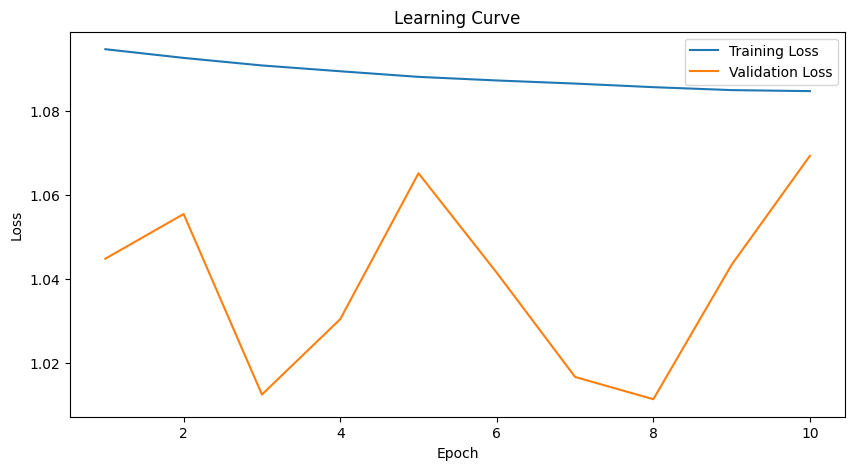

In [13]:
# Plot learning curve
plt.figure(figsize=(10, 5))
print(train_losses)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

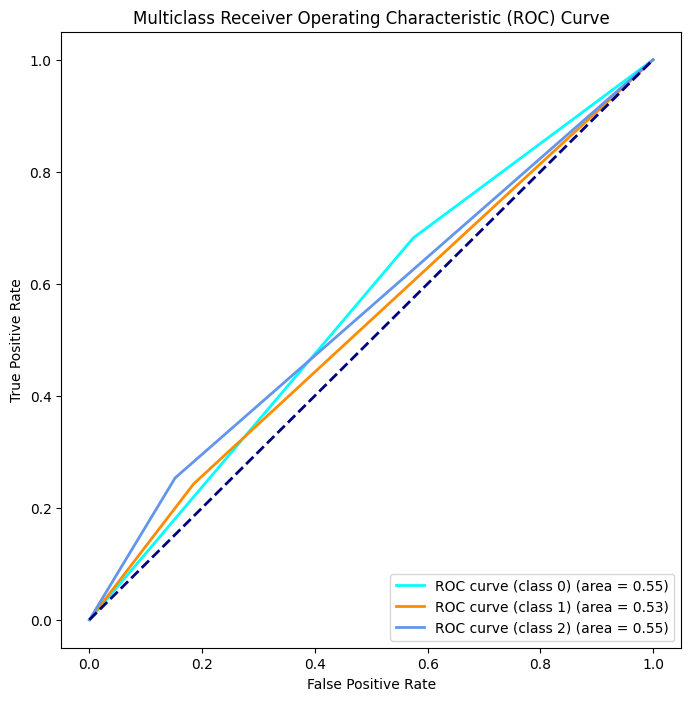

In [14]:
# # Plot ROC curve

# Compute ROC curve and ROC area for each class
# Convert continuous values to integers (if needed)
all_labels = np.round(all_labels).astype(int)
all_predictions = np.round(all_predictions).astype(int)

# Convert labels and predictions to one-hot encoding
all_labels_onehot = np.eye(output_dim)[all_labels]
all_predictions_onehot = np.eye(output_dim)[all_predictions]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(output_dim):
    fpr[i], tpr[i], _ = roc_curve(all_labels_onehot[:, i], all_predictions_onehot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(output_dim), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve (class {i}) (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


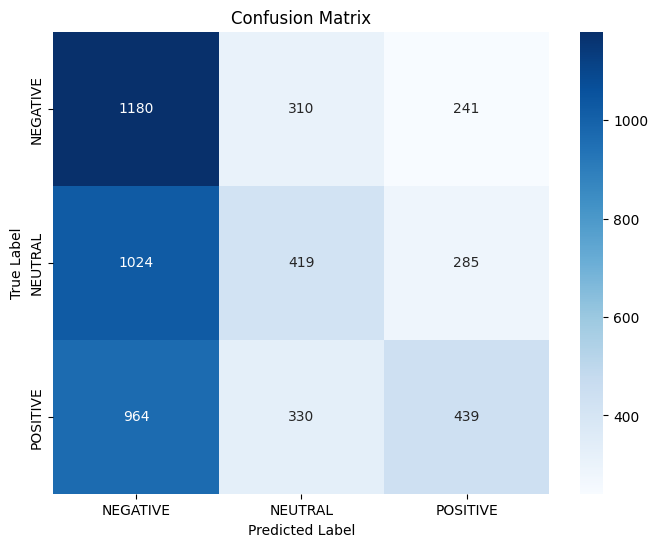

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert continuous values to integers (if needed)
all_labels = np.round(all_labels).astype(int)
all_predictions = np.round(all_predictions).astype(int)

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [17]:
DATASET_COLUMNS=['New_ID','text','party']
DATASET_ENCODING = "UTF-8"
test_dataset = pd.read_csv('csv/test_set.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
test_dataset = test_dataset[1:]
test_dataset.fillna("", inplace=True)

test_dataset = total_cleaning(test_dataset)    

In [20]:
test_dataset = test_dataset.copy()
test_dataset['word_embeddings'] = test_dataset['text'].apply(lambda x: get_embeddings(x, w2v_model))


# Convert text embeddings to PyTorch tensors
test_dataset['word_embeddings'] = test_dataset['word_embeddings'].fillna(method='ffill')
test_dataset = test_dataset.dropna(subset=['word_embeddings'])
test_features = torch.stack([torch.tensor(embedding) for embedding in test_dataset['word_embeddings'].dropna().tolist()])

# Make predictions using the trained model
model.eval()
with torch.no_grad():
    test_outputs = model(test_features)
    _, test_predicted = torch.max(test_outputs, 1)

# Decode labels if needed
test_predictions = label_encoder.inverse_transform(test_predicted.numpy())

# Now you have predictions for your test dataset
print(test_predictions)
test_dataset['party'] = test_predictions

result_df = pd.DataFrame({'Id': test_dataset.New_ID, 'Predicted': test_predictions})

# Save the result to a new CSV file
result_df.to_csv('csv/submission.csv', index=False)
print(" -------------------------- New CSV edited and submission created ----------------- ")

C:\Users\theodoros.minaidis\AppData\Local\Temp\ipykernel_20824\1426808355.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_dataset['word_embeddings'] = test_dataset['word_embeddings'].fillna(method='ffill')


['NEUTRAL' 'NEGATIVE' 'POSITIVE' ... 'NEGATIVE' 'NEGATIVE' 'NEGATIVE']
 -------------------------- New CSV edited and submission created ----------------- 
